In [2]:
import torch as th
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from einops import einsum, rearrange, reduce
from functools import partial
from matplotlib import pyplot as plt
import numpy as np
import math

In [7]:
device = th.device("cuda")

# Prepare Data

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
#dictionary:
#b'batch_label': b'training batch 1 of 5'
#b'labels': labels for each image
#b'data': image array
#b'filenames': filenames of the images
flattened_images = unpickle("./cifar-10-batches-py/data_batch_1")

In [5]:
#shape of flattened_images[b'data']: (batch_size, height*width*channels)

#input shape: (batch_size, height*width*channels)
def channelizeImages(flattened_images):
    #reshape to (batch_size, channels, height*width)
    images = rearrange(flattened_images[b'data'], 'b (c i) -> b c i', c=3, i=32*32)
    #reshape to (batch_size, channels, height, width)
    images = rearrange(images, 'b c (h w) -> b c h w', h=32, w=32)
    return images

In [6]:
images = channelizeImages(flattened_images)
images.shape

(10000, 3, 32, 32)

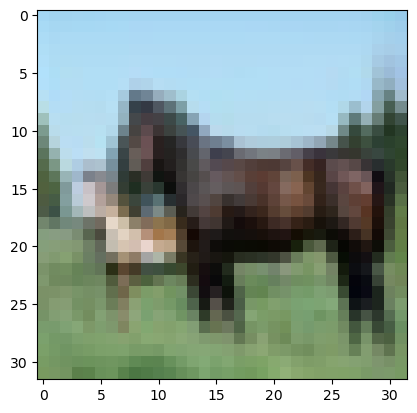

In [7]:
plt.imshow(rearrange(images[12,...], 'c h w -> h w c'))

In [8]:
class ImageDataset(Dataset):
    def __init__(self, data, sample_size):
        self.data = data
        self.sample_size = sample_size
    def __len__(self):
        return self.sample_size
    def __getitem__(self, idx):
        return self.data[idx]

# Model

In [12]:
dataset = ImageDataset(images, len(images))
data_loader = DataLoader(dataset, batch_size=1)

In [13]:
data_iter = iter(data_loader)

In [14]:
(next(data_iter)/155.).shape

torch.Size([1, 3, 32, 32])

# Vanilla UNet

Reproduced from paper  <a style="display:inline" href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation
 </a>

In [19]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=kernel_size, padding=padding)
    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(x)

In [20]:
class Upsample(nn.Module):
    def __init__(self, in_channel, out_channel, scale_factor, padding=1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=scale_factor, mode='nearest')
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=padding)
    def forward(self, x):
        x = self.up(x)
        return self.conv(x)

In [16]:
class VanillaUNet(nn.Module):
    def __init__(self, in_channel, channels, padding=1):
        super().__init__()
        self.in_channel = in_channel
        self.channels = channels
        self.down_channels = list(zip(channels[:-2], channels[1:-1]))
        self.up_channels = list(zip(reversed(channels[2:]), reversed(channels[1:-1])))
        
        self.in_conv = nn.Conv2d(in_channel, channels[0], kernel_size=3, padding=padding)
        self.down_stage = nn.ModuleList()
        self.mid_stage = Block(channels[-2], channels[-1], kernel_size=3, padding=padding)
        self.up_stage = nn.ModuleList()
        
        for in_ch, out_ch in self.down_channels:
            self.down_stage.append(nn.ModuleList([Block(in_ch, out_ch, kernel_size=3, padding=padding),
                                                  nn.MaxPool2d(kernel_size=2, stride=2)]))
        for in_ch, out_ch in self.up_channels:
            self.up_stage.append(nn.ModuleList([Upsample(in_ch, out_ch, scale_factor=2, padding=padding),
                                                Block(in_ch, out_ch, kernel_size=3, padding=padding)]))
        self.out_conv = nn.Conv2d(channels[1], in_channel, kernel_size=3, padding=padding)
    def forward(self, x):
        resnet = []
        x = self.in_conv(x)
        for block, down_sample in self.down_stage:
            x = block(x)
            resnet.append(x)
            x = down_sample(x)
        x = self.mid_stage(x)
        for block, up_sample in self.up_stage:
            x = up_sample(x)
            x = block(th.cat((x, self.crop(resnet.pop(), x)), dim=1))
        x = self.out_conv(x)
        return x
    def crop(self, x, x_crop):
        crop_height, crop_width = x_crop.shape[2:]
        height, width = x.shape[2:]
        ix = int((height-crop_height)/2)
        iy = int((width-crop_width)/2)
        return x[...,ix:ix+crop_height, iy:iy+crop_width]

In [17]:
in_channel = 3
channels = [32, 64, 128]

vanilla_unet = VanillaUNet(in_channel, channels)

In [23]:
vanilla_unet

VanillaUNet(
  (in_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (down_stage): ModuleList(
    (0): ModuleList(
      (0): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (mid_stage): Block(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (up_stage): ModuleList(
    (0): ModuleList(
      (0): Upsample(
        (up): Upsample(scale_factor=2.0, mode='nearest')
        (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
  (out_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
)

In [24]:
vanilla_unet.down_stage

ModuleList(
  (0): ModuleList(
    (0): Block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [115]:
print(vanilla_unet(next(data_iter)/155.).shape)

torch.Size([1, 3, 32, 32])


# Attention-UNet

Source: <a href="https://huggingface.co/blog/annotated-diffusion">The Annotated Diffusion Model</a>

## Components

### Standardised Convolution and Group Norm

When used _Group Normalization_ together with _Weight Standardization_, the performance of model improves and becomes comparable even for small training batch sizes.

<a href="https://arxiv.org/abs/1803.08494v3">Group Normalization</a>

<a href="https://arxiv.org/abs/1903.10520">Micro-Batch Training with Batch-Channel Normalization and Weight Standardization</a>

<a href="https://arxiv.org/abs/1912.11370">Big Transfer (BiT): General Visual Representation Learning</a>

In [220]:
class WSConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eps = 1.e-5
    def forward(self, x):
        #mean and var are calculated over in_channel and kernel
        #note that the mean and var are not detached from autograd
        mean = reduce(self.weight, "o ... -> o 1 1 1", "mean")
        std = (reduce(self.weight, "o ... -> o 1 1 1", partial(th.var, unbiased=False)) + self.eps).sqrt()
        normalized_weight = (self.weight-mean)/std

        return F.conv2d(x, normalized_weight, bias=self.bias, stride=self.stride, padding=self.padding, groups=self.groups)

In [208]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1, groups=8):
        super().__init__()
        self.conv = WSConv2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.norm = nn.GroupNorm(groups, out_channel)
        self.act = nn.SiLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return self.act(x)

### ResNet

Each resnet block consists of two standardized convolutions with a skip connection.

In [201]:
class ResNet(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()
        self.resnet_conv = nn.Conv2d(in_channel, out_channel, kernel_size=1, padding=0)
        self.conv1 = Conv2dBlock(in_channel, out_channel, kernel_size=kernel_size, padding=padding)
        self.conv2 = Conv2dBlock(out_channel, out_channel, kernel_size=kernel_size, padding=padding)
    def forward(self, x):
        res = self.resnet_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x + res

### Attention

For a given batch of images with $C$ channels and $(h,w)$ image dimension, the attention block calculates image whose pixels are attention weighted sum over all pixels. The attention is calculated as follows.

The image dimension for each channel is flattented. The attention values are calculated between each query and key pixels with number of channels being the dimension of each pixel. The value pixels are summed weighted by the attention values. The image is unflattened.

In [170]:
class Attention(nn.Module):
    def __init__(self, in_channel, num_heads=4):
        super().__init__()
        self.in_channel = in_channel
        self.num_heads = num_heads
        self.qkv = nn.Conv2d(self.in_channel, self.in_channel*self.num_heads*3, kernel_size=1)
        self.out = nn.Conv2d(self.in_channel*self.num_heads, self.in_channel, kernel_size=1)
    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.qkv(x)
        qkv = rearrange(qkv, "b (hd c) h w -> b hd c (h w)", hd=self.num_heads)
        q, k, v = qkv.chunk(3, dim=2)
        
        scale = 1/math.sqrt(q.shape[-1])
        attn = einsum(q, k, "b hd c d1, b hd c d2 -> b hd d1 d2")*scale
        attn = attn.softmax(dim=-1)
        
        out = einsum(attn, v, "b hd d1 d2, b hd c d2 -> b hd c d1")
        out = rearrange(out, "b hd c (h1 w1) -> b (hd c) h1 w1", h1=h, w1=w)
        return self.out(out)

## Model

In [171]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channel, channels):
        super().__init__()
        self.in_channel = in_channel
        self.channels = channels
        
        self.in_conv = nn.Conv2d(self.in_channel, self.channels[0], kernel_size=3, padding=1)
        self.down_stage = nn.ModuleList()
        self.mid_stage = nn.ModuleList()
        self.up_stage = nn.ModuleList()
        self.out_conv = nn.Conv2d(self.channels[1], self.in_channel, kernel_size=3, padding=1)

        self.down_channels = list(zip(self.channels[:-2], self.channels[1:-1]))
        self.up_channels = list(zip(reversed(self.channels[2:]), reversed(self.channels[1:-1])))

        for in_ch, out_ch in self.down_channels:
            self.down_stage.append(nn.ModuleList([ResNet(in_ch, out_ch), ResNet(out_ch, out_ch),
                                                  Attention(out_ch),
                                                  nn.MaxPool2d(kernel_size=2, stride=2)]))
        self.mid_stage.append(ResNet(self.channels[-2], self.channels[-1]))
        self.mid_stage.append(Attention(self.channels[-1]))
        self.mid_stage.append(ResNet(self.channels[-1], self.channels[-1]))

        for in_ch, out_ch in self.up_channels:
            self.up_stage.append(nn.ModuleList([Upsample(in_ch, out_ch, scale_factor=2),
                                                ResNet(in_ch, out_ch), ResNet(out_ch, out_ch),
                                                Attention(out_ch)]))
    def forward(self, x):
        x = self.in_conv(x)
        resnet = []
        for block1, block2, attn, down in self.down_stage:
            x = block1(x)
            resnet.append(x)
            x = block2(x)
            x += attn(x)
            x = down(x)
        x = self.mid_stage[0](x)
        x += self.mid_stage[1](x)
        x = self.mid_stage[2](x)

        for up, block1, block2, attn in self.up_stage:
            x = up(x)
            x = th.cat((x, resnet.pop()), dim=1)
            x = block1(x)
            x = block2(x)
            x += attn(x)
        x = self.out_conv(x)
        return x
    @th.no_grad()
    def predict(self, x):
        return self(x)

In [202]:
in_channel = 3
channels = [32, 64, 128]

attn_unet = AttentionUNet(in_channel, channels)